# DWI inpainting with VAE-GAN

Here, we will add a patchwise discriminator to the U-VQVAE model to further fine tune the reconstructed image. We follow the guidance of Larsen et al. 2016 for training this model.

### Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import numpy as np
import time, datetime
from Dataset import Dataset
from Models import *
import pickle, os

# ===============================================================
# SPECIFY THESE
# ===============================================================
num_train = 40000
batch_size = 128
crop = False
max_epochs = 50
cpu_batch_load_workers = 6
log_every_num_batches = 10
embedding_dim = 32
num_embeddings = 512
model_save_path = 'models/gan_vqvae_skip/'
d_input_shape = (1,96,96,64)
g_filters = 16
d_filters = 8
pad = False
normalize = True
num_corrupt = 8
train_corrupt_prob = 1.0
valid_corrupt_prob = 1.0

# Learning rate for optimizers
lrD = 0.0004
lrG = 0.0001
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# ===============================================================
# end
# ===============================================================

### Weights initialization

We want our weights to be randomly initialized from a normal distribution with mean 0, STD 0.02. We use a custom weights initialization function which should take a model and change their weights.

In [2]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Dataset

In [3]:
# Parameters
params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': cpu_batch_load_workers}

# Datasets
dwi_files1 = np.loadtxt('ncanda/X_files.txt', dtype=str)
dwi_files2 = np.loadtxt('X_resized_files.txt', dtype=str)
dwi_files_npy = np.concatenate((dwi_files1, dwi_files2))
print('Total number of samples: %d' % dwi_files_npy.shape[0])
np.random.seed(420)
np.random.shuffle(dwi_files_npy)
num_train = int(0.8 * dwi_files_npy.shape[0])
num_val = dwi_files_npy.shape[0] - num_train

# Generators
training_set = Dataset(dwi_files_npy[:num_train], corrupt_prob = train_corrupt_prob, crop = crop, pad = pad, tanh_norm = normalize, num_corrupt = num_corrupt)
training_generator = data.DataLoader(training_set, **params)

validation_set = Dataset(dwi_files_npy[num_train:], corrupt_prob = valid_corrupt_prob, crop = crop, pad = pad, tanh_norm = normalize, num_corrupt = num_corrupt)
validation_generator = data.DataLoader(validation_set, **params)

# Setup GPU if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

Total number of samples: 420487


### Model

In [4]:
generator = VQVAE3D(d_input_shape[0], g_filters,
                    embedding_dim = embedding_dim, 
                    num_embeddings = num_embeddings, 
                    skip_connections = True,
                    batchnorm = True)

generator.apply(weights_init)

# generator = torch.load('models/gan_vqvae_skip/generator/Epoch_10_Train_loss_0.9239_Test_loss_1.0713.pth')

generator.to(device)

print(generator)

VQVAE3D(
  (encoder): VQEncoder(
    (conv1): Sequential(
      (0): Conv3d(1, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): Sequential(
      (0): Conv3d(16, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv3): Sequential(
      (0): Conv3d(32, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv4): Sequential(
      (0): Conv3d(64, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    )
  )
  (quantization): VectorQuantizerEMA(
    (_embedding): Embedding(512, 32)
  )
  (decoder): VQDecoder_skip(
    (conv1): Sequential(
      (0): ConvTranspose3d(32, 64, k

In [5]:
discriminator = PatchDiscriminator(d_input_shape[0], d_filters)

discriminator.apply(weights_init)

# discriminator = torch.load('models/gan_vqvae_skip/discriminator/Epoch_10_Train_loss_real_0.7564_Train_loss_fake_0.5758.pth')

discriminator.to(device)

print(discriminator)

PatchDiscriminator(
  (conv1): Sequential(
    (0): Conv3d(1, 8, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv3d(8, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (3): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv3d(16, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (6): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
  )
  (conv2): Sequential(
    (0): Conv3d(32, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv3d(64, 1, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (4): Sigmoid()
  )
)


### Loss and optimizers

There are three loss functions - one for the VQ loss (codebook, commitment) which is already associated with the model, one for reconstruction loss for the generator, and the adversarial loss that updates both the generator and the discriminator.

In [6]:
from skimage.metrics import structural_similarity

adversarial_loss = nn.BCELoss(reduction = 'mean')

intermediate_loss = nn.MSELoss(reduction = 'mean')

image_range = 2 if normalize else 1

def ssim(tensor_image_batch_pred, tensor_image_batch_target, data_range):
    x_recon = tensor_image_batch_pred.detach().cpu().numpy().squeeze()
    x_clean = tensor_image_batch_target.detach().cpu().numpy().squeeze()
    
    structsim = np.mean([structural_similarity(x_clean[i], x_recon[i], data_range = data_range) for i in range(x_clean.shape[0])])
    
    return structsim
        
    
optimizerD = optim.Adam(discriminator.parameters(), lr=lrD, betas=(beta1, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=lrG, betas=(beta1, 0.999))

# Save a test image to use for visualizing generator performance
test_batch_in, test_batch_out = next(iter(validation_generator))
test_image_bad, test_image_good = test_batch_in[0], test_batch_out[0]
test_image_bad, test_image_good = test_image_bad.unsqueeze(0).to(device), test_image_good.unsqueeze(0).to(device)
torch.save(test_image_bad, os.path.join(model_save_path, 'test_image_bad.pth'))
torch.save(test_image_good, os.path.join(model_save_path, 'test_image_good.pth'))

# test_image_good = torch.load(os.path.join(model_save_path, 'test_image_good.pth'))
# test_image_bad = torch.load(os.path.join(model_save_path, 'test_image_bad.pth'))
# test_image_good, test_image_bad = test_image_good.to(device), test_image_bad.to(device)

### Training

In [ ]:
history = {'G': [], 'Dreal': [], 'Dfake': [], 'Grecon': [], 'Gadv': [], 'Gvq': [], 'step': [], 'SSIM': []}

# with open(os.path.join(model_save_path, 'history.p'), 'rb') as f:
#     history = pickle.load(f)

g_test_dir = os.path.join(model_save_path, 'generator')
d_test_dir = os.path.join(model_save_path, 'discriminator')
if not os.path.exists(g_test_dir):
    os.makedirs(g_test_dir)
    os.makedirs(d_test_dir)


for epoch in range(max_epochs):
#for epoch in range(10,70,1):
    print('====> Begin epoch {}'.format(epoch+1))
    print()
    """
    Training
    """
    t0 = time.time()
    generator.train()
    discriminator.train()
    for batch_id, (batch_corrupt, batch_clean) in enumerate(training_generator):
        batch_run_time = time.time()
        training_batch_size = batch_corrupt.size(0)
        label_shape = (training_batch_size, d_input_shape[0], d_input_shape[1] // 2**4, d_input_shape[2] // 2**4, d_input_shape[3] // 2**4)
        #label_shape = (training_batch_size, 1)
        real_label = torch.ones(label_shape).to(device)
        fake_label = torch.zeros(label_shape).to(device)
        # Transfer to GPU
        batch_corrupt, batch_clean = batch_corrupt.to(device), batch_clean.to(device)
        
        #================ TRAIN DISCRIMINATOR ===================
        # Clear optimizer gradients
        optimizerD.zero_grad()
        # Train D to recognize real images as real.
        clean_out, clean_intermediate = discriminator(batch_clean)
        clean_loss = adversarial_loss(clean_out, real_label * 0.9)
        # Train D to recognize fake images as fake.
        outputs = generator(batch_corrupt)
        loss_vq = outputs['vq_loss']
        inpainted = outputs['x_out']
        fake_out, fake_intermediate = discriminator(inpainted)
        fake_loss = adversarial_loss(fake_out, fake_label)
        # Backprop + optimize
        lossD = (clean_loss + fake_loss) / 2
        lossD.backward()
        optimizerD.step()
        
        #================ TRAIN GENERATOR =======================
        # Clear optimizer gradients
        optimizerG.zero_grad()
        # Train G so that D recognizes G(z) as real.
        outputs = generator(batch_corrupt)
        loss_vq = outputs['vq_loss']
        inpainted = outputs['x_out']
        fake_out, fake_intermediate = discriminator(inpainted)
        clean_out, clean_intermediate = discriminator(batch_clean)
        loss_adv = adversarial_loss(fake_out, real_label)
#         # Reconstruction loss
#         loss_recon = reconstruction_loss(inpainted, batch_clean)
        # Discriminator representation loss
        loss_recon = intermediate_loss(fake_intermediate, clean_intermediate)
        lossG = loss_recon + loss_adv + loss_vq
        # Backprop + optimize
        lossG.backward()
        optimizerG.step()
        batch_run_time = time.time() - batch_run_time
        et = batch_run_time * (len(training_generator) - batch_id) * 3
        #================ LOG AND SAVE ==========================
        # Print progress
        if (batch_id + 1) % log_every_num_batches == 0 or batch_id == 0:
            history['Dreal'].append(clean_loss.item())
            history['Dfake'].append(fake_loss.item())
            history['G'].append(lossG.item())
            history['Grecon'].append(loss_recon.item())
            history['Gadv'].append(loss_adv.item())
            history['Gvq'].append(loss_vq.item())
            history['step'].append(batch_id + 1 + epoch * len(training_generator))
            history['SSIM'].append(ssim(inpainted, batch_clean, image_range))
            # Save history
            with open(os.path.join(model_save_path, 'history.p'), 'wb') as f:
                pickle.dump(history, f)
            print('Epoch: {:d} [{:d}/{:d}] | D Real: {:.6f} | D Fake: {:.6f} | G Recon: {:.6f} | G Adv: {:.6f} | G VQ: {:.6f} | ET - {:s}'.format(
                    epoch+1, batch_id+1, len(training_generator),
                    clean_loss.data, fake_loss.data, loss_recon.data,
                    loss_adv.data, loss_vq.data, str(datetime.timedelta(seconds=int(et)))))

    
    """
    Testing
    """
    generator.eval()
    discriminator.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_id, (batch_corrupt, batch_clean) in enumerate(validation_generator):
            test_batch_size = batch_corrupt.size(0)
            label_shape = (test_batch_size, d_input_shape[0], d_input_shape[1] // 2**4, d_input_shape[2] // 2**4, d_input_shape[3] // 2**4)
            #label_shape = (test_batch_size, 1)
            real_label = torch.ones(label_shape).to(device)
            fake_label = torch.zeros(label_shape).to(device)
            # Transfer to GPU
            batch_corrupt, batch_clean = batch_corrupt.to(device), batch_clean.to(device)
            # Forward pass through the model
            outputs = generator(batch_corrupt)
            loss_vq = outputs['vq_loss']
            inpainted = outputs['x_out']
            # Calculate D loss on real images
            clean_out, clean_intermediate = discriminator(batch_clean)
            clean_loss = adversarial_loss(clean_out, real_label)
            # Calculate D loss on fake images
            fake_out, fake_intermediate = discriminator(inpainted)
            fake_loss = adversarial_loss(fake_out, fake_label)
            # Calculate G adversarial loss
            loss_adv = adversarial_loss(fake_out, real_label)
#             # Reconstruction loss
#             loss_recon = reconstruction_loss(inpainted, batch_clean)
            # Discriminator representation loss
            loss_recon = intermediate_loss(fake_intermediate, clean_intermediate)
            lossG = g_loss_scheduler(loss_recon, loss_adv, loss_vq, test = True)
            test_loss += lossG.item()
            
            # Save a test image
            if batch_id == 0:
                outputs = generator(test_image_bad)
                test_inpaint = outputs['x_out']
                test_fake_out, _ = discriminator(test_inpaint)
                g_img_path = os.path.join(g_test_dir, 'image_epoch%d.pth' % (epoch+1))
                d_img_path = os.path.join(d_test_dir, 'image_epoch%d.pth' % (epoch+1))
                torch.save(test_inpaint, g_img_path)
                torch.save(test_fake_out, d_img_path)
                
                
    t_epoch = time.time() - t0
    test_loss /= len(validation_generator)
    print('====> Test set G loss: {:.6f}\tTime elapsed in this epoch: {:s}'.format(
        test_loss, str(datetime.timedelta(seconds=int(t_epoch)))))
    print()
    
    g_model_path = os.path.join(model_save_path, 'generator', 'Epoch_{}_Train_loss_{:.4f}_Test_loss_{:.4f}.pth'.format(epoch+1, history['G'][-1], test_loss))
    # Save model
    torch.save(generator, g_model_path)
    
    d_model_path = os.path.join(model_save_path, 'discriminator', 'Epoch_{}_Train_loss_real_{:.4f}_Train_loss_fake_{:.4f}.pth'.format(epoch+1, history['Dreal'][-1], history['Dfake'][-1]))
    # Save model
    torch.save(discriminator, d_model_path)

====> Begin epoch 11

Epoch: 11 [1/2629] | D Real: 0.879778 | D Fake: 0.491615 | G Recon: 0.029749 | G Adv: 0.885442 | G VQ: 0.016903 | ET - 22:11:50
Epoch: 11 [10/2629] | D Real: 0.739207 | D Fake: 0.583904 | G Recon: 0.037970 | G Adv: 0.911655 | G VQ: 0.020175 | ET - 2:20:54
Epoch: 11 [20/2629] | D Real: 0.696746 | D Fake: 0.637303 | G Recon: 0.037827 | G Adv: 0.924698 | G VQ: 0.023348 | ET - 2:21:50
Epoch: 11 [30/2629] | D Real: 0.833870 | D Fake: 0.314308 | G Recon: 0.045444 | G Adv: 1.606460 | G VQ: 0.021672 | ET - 2:22:13
Epoch: 11 [40/2629] | D Real: 0.600029 | D Fake: 0.708720 | G Recon: 0.055397 | G Adv: 1.053329 | G VQ: 0.025429 | ET - 2:20:42
Epoch: 11 [50/2629] | D Real: 0.810502 | D Fake: 0.461082 | G Recon: 0.059808 | G Adv: 1.021809 | G VQ: 0.024482 | ET - 2:20:25
Epoch: 11 [60/2629] | D Real: 0.566427 | D Fake: 0.569953 | G Recon: 0.055027 | G Adv: 1.159524 | G VQ: 0.022320 | ET - 2:20:08
Epoch: 11 [70/2629] | D Real: 0.637931 | D Fake: 0.216421 | G Recon: 0.073566 | G 

Epoch: 11 [640/2629] | D Real: 0.766214 | D Fake: 0.520313 | G Recon: 0.036198 | G Adv: 0.888901 | G VQ: 0.027743 | ET - 1:46:20
Epoch: 11 [650/2629] | D Real: 0.740662 | D Fake: 0.561762 | G Recon: 0.036586 | G Adv: 0.916343 | G VQ: 0.026269 | ET - 1:41:24
Epoch: 11 [660/2629] | D Real: 0.756132 | D Fake: 0.561467 | G Recon: 0.038112 | G Adv: 0.893630 | G VQ: 0.028933 | ET - 1:46:01
Epoch: 11 [670/2629] | D Real: 0.768274 | D Fake: 0.579558 | G Recon: 0.037539 | G Adv: 0.905840 | G VQ: 0.028983 | ET - 1:44:49
Epoch: 11 [680/2629] | D Real: 0.733139 | D Fake: 0.580372 | G Recon: 0.038044 | G Adv: 0.944267 | G VQ: 0.028046 | ET - 1:42:23
Epoch: 11 [690/2629] | D Real: 0.767295 | D Fake: 0.569613 | G Recon: 0.036833 | G Adv: 0.849304 | G VQ: 0.029995 | ET - 1:44:38
Epoch: 11 [700/2629] | D Real: 0.788065 | D Fake: 0.545498 | G Recon: 0.039004 | G Adv: 0.919649 | G VQ: 0.028888 | ET - 1:43:35
Epoch: 11 [710/2629] | D Real: 0.760796 | D Fake: 0.666435 | G Recon: 0.042972 | G Adv: 0.892058 

Epoch: 11 [1280/2629] | D Real: 0.692572 | D Fake: 0.655103 | G Recon: 0.039490 | G Adv: 0.868401 | G VQ: 0.028619 | ET - 1:12:22
Epoch: 11 [1290/2629] | D Real: 0.568080 | D Fake: 0.577721 | G Recon: 0.054399 | G Adv: 1.075750 | G VQ: 0.027771 | ET - 1:11:17
Epoch: 11 [1300/2629] | D Real: 0.672266 | D Fake: 0.320482 | G Recon: 0.057075 | G Adv: 1.457256 | G VQ: 0.028863 | ET - 1:11:40
Epoch: 11 [1310/2629] | D Real: 0.549187 | D Fake: 0.181924 | G Recon: 0.086705 | G Adv: 1.912145 | G VQ: 0.030833 | ET - 1:11:06
Epoch: 11 [1320/2629] | D Real: 0.572410 | D Fake: 0.185898 | G Recon: 0.067977 | G Adv: 2.007509 | G VQ: 0.027973 | ET - 1:08:11
Epoch: 11 [1330/2629] | D Real: 0.443532 | D Fake: 0.174436 | G Recon: 0.085355 | G Adv: 2.057263 | G VQ: 0.028349 | ET - 1:09:37
Epoch: 11 [1340/2629] | D Real: 0.520923 | D Fake: 0.422071 | G Recon: 0.054813 | G Adv: 1.454857 | G VQ: 0.030000 | ET - 1:08:48
Epoch: 11 [1350/2629] | D Real: 0.546517 | D Fake: 0.605617 | G Recon: 0.053463 | G Adv: 1

Epoch: 11 [1920/2629] | D Real: 2.263926 | D Fake: 0.234955 | G Recon: 0.068843 | G Adv: 1.891370 | G VQ: 0.034270 | ET - 0:38:00
Epoch: 11 [1930/2629] | D Real: 0.947414 | D Fake: 0.481179 | G Recon: 0.035483 | G Adv: 1.013161 | G VQ: 0.030155 | ET - 0:35:22
Epoch: 11 [1940/2629] | D Real: 0.840545 | D Fake: 0.601945 | G Recon: 0.025286 | G Adv: 0.884241 | G VQ: 0.033944 | ET - 0:37:15
Epoch: 11 [1950/2629] | D Real: 0.819774 | D Fake: 0.560129 | G Recon: 0.026085 | G Adv: 0.907501 | G VQ: 0.034531 | ET - 0:35:21
Epoch: 11 [1960/2629] | D Real: 0.760342 | D Fake: 0.578873 | G Recon: 0.025386 | G Adv: 0.882813 | G VQ: 0.028584 | ET - 0:36:09
Epoch: 11 [1970/2629] | D Real: 0.748194 | D Fake: 0.555170 | G Recon: 0.028547 | G Adv: 0.989016 | G VQ: 0.028780 | ET - 0:34:17
Epoch: 11 [1980/2629] | D Real: 0.717811 | D Fake: 0.545134 | G Recon: 0.038489 | G Adv: 0.950386 | G VQ: 0.035456 | ET - 0:34:07
Epoch: 11 [1990/2629] | D Real: 0.759933 | D Fake: 0.499879 | G Recon: 0.035700 | G Adv: 0

Epoch: 11 [2560/2629] | D Real: 0.475101 | D Fake: 0.498230 | G Recon: 0.063484 | G Adv: 1.661156 | G VQ: 0.032746 | ET - 0:03:35
Epoch: 11 [2570/2629] | D Real: 0.499652 | D Fake: 0.244819 | G Recon: 0.074030 | G Adv: 1.766472 | G VQ: 0.034563 | ET - 0:03:14
Epoch: 11 [2580/2629] | D Real: 0.581511 | D Fake: 0.093634 | G Recon: 0.092716 | G Adv: 2.656823 | G VQ: 0.035789 | ET - 0:02:41
Epoch: 11 [2590/2629] | D Real: 0.512140 | D Fake: 0.211941 | G Recon: 0.059230 | G Adv: 1.922418 | G VQ: 0.035060 | ET - 0:02:07
Epoch: 11 [2600/2629] | D Real: 0.555763 | D Fake: 0.111082 | G Recon: 0.062994 | G Adv: 2.436882 | G VQ: 0.035498 | ET - 0:01:36
Epoch: 11 [2610/2629] | D Real: 0.639114 | D Fake: 0.147906 | G Recon: 0.067544 | G Adv: 2.356858 | G VQ: 0.033543 | ET - 0:01:04
Epoch: 11 [2620/2629] | D Real: 0.519388 | D Fake: 0.360645 | G Recon: 0.068559 | G Adv: 1.474998 | G VQ: 0.037573 | ET - 0:00:32
====> Test set G loss: 0.750502	Time elapsed in this epoch: 2:17:20

====> Begin epoch 12


Epoch: 12 [560/2629] | D Real: 0.750967 | D Fake: 0.563836 | G Recon: 0.029829 | G Adv: 0.935016 | G VQ: 0.021623 | ET - 1:50:37
Epoch: 12 [570/2629] | D Real: 0.769059 | D Fake: 0.551607 | G Recon: 0.032148 | G Adv: 0.927603 | G VQ: 0.024489 | ET - 1:51:58
Epoch: 12 [580/2629] | D Real: 0.778682 | D Fake: 0.558013 | G Recon: 0.030532 | G Adv: 0.898674 | G VQ: 0.024356 | ET - 1:49:25
Epoch: 12 [590/2629] | D Real: 0.813947 | D Fake: 0.533152 | G Recon: 0.033532 | G Adv: 0.949620 | G VQ: 0.027072 | ET - 1:49:41
Epoch: 12 [600/2629] | D Real: 0.759371 | D Fake: 0.554198 | G Recon: 0.031089 | G Adv: 0.893205 | G VQ: 0.025958 | ET - 1:46:56
Epoch: 12 [610/2629] | D Real: 0.697710 | D Fake: 0.604174 | G Recon: 0.033899 | G Adv: 0.961365 | G VQ: 0.031196 | ET - 1:48:37
Epoch: 12 [620/2629] | D Real: 0.804811 | D Fake: 0.513954 | G Recon: 0.034155 | G Adv: 0.938590 | G VQ: 0.031616 | ET - 1:47:16
Epoch: 12 [630/2629] | D Real: 0.644392 | D Fake: 0.651741 | G Recon: 0.038933 | G Adv: 0.947978 

Epoch: 12 [1200/2629] | D Real: 0.771814 | D Fake: 0.248640 | G Recon: 0.051845 | G Adv: 1.905845 | G VQ: 0.032947 | ET - 1:17:10
Epoch: 12 [1210/2629] | D Real: 0.896635 | D Fake: 0.456390 | G Recon: 0.051615 | G Adv: 1.204703 | G VQ: 0.028868 | ET - 1:16:42
Epoch: 12 [1220/2629] | D Real: 0.521642 | D Fake: 0.861631 | G Recon: 0.061043 | G Adv: 1.272306 | G VQ: 0.030913 | ET - 1:15:36
Epoch: 12 [1230/2629] | D Real: 0.482287 | D Fake: 0.512710 | G Recon: 0.079461 | G Adv: 1.297799 | G VQ: 0.029664 | ET - 1:15:02
Epoch: 12 [1240/2629] | D Real: 0.564473 | D Fake: 0.675992 | G Recon: 0.047032 | G Adv: 1.455308 | G VQ: 0.027402 | ET - 1:14:33
Epoch: 12 [1250/2629] | D Real: 0.631482 | D Fake: 0.185110 | G Recon: 0.074902 | G Adv: 2.262301 | G VQ: 0.030388 | ET - 1:09:07
Epoch: 12 [1260/2629] | D Real: 0.406865 | D Fake: 0.310280 | G Recon: 0.060341 | G Adv: 1.907856 | G VQ: 0.037392 | ET - 1:13:15
Epoch: 12 [1270/2629] | D Real: 0.555819 | D Fake: 0.307359 | G Recon: 0.056400 | G Adv: 1

Epoch: 12 [1840/2629] | D Real: 0.403664 | D Fake: 0.257053 | G Recon: 0.067233 | G Adv: 2.234052 | G VQ: 0.026953 | ET - 0:40:40
Epoch: 12 [1850/2629] | D Real: 0.496582 | D Fake: 0.258798 | G Recon: 0.057123 | G Adv: 2.005297 | G VQ: 0.026263 | ET - 0:40:29
Epoch: 12 [1860/2629] | D Real: 0.461259 | D Fake: 0.118241 | G Recon: 0.069983 | G Adv: 2.726412 | G VQ: 0.024652 | ET - 0:41:17
Epoch: 12 [1870/2629] | D Real: 0.810584 | D Fake: 0.288490 | G Recon: 0.062643 | G Adv: 2.145750 | G VQ: 0.022885 | ET - 0:37:38
Epoch: 12 [1880/2629] | D Real: 0.530591 | D Fake: 0.481506 | G Recon: 0.052079 | G Adv: 2.034618 | G VQ: 0.023656 | ET - 0:40:16
Epoch: 12 [1890/2629] | D Real: 0.469680 | D Fake: 0.229621 | G Recon: 0.059678 | G Adv: 2.324240 | G VQ: 0.024072 | ET - 0:39:24
Epoch: 12 [1900/2629] | D Real: 0.687398 | D Fake: 0.065769 | G Recon: 0.067870 | G Adv: 3.256463 | G VQ: 0.025911 | ET - 0:39:05
Epoch: 12 [1910/2629] | D Real: 0.662647 | D Fake: 0.131006 | G Recon: 0.075858 | G Adv: 2

Epoch: 12 [2480/2629] | D Real: 0.781460 | D Fake: 0.592937 | G Recon: 0.017723 | G Adv: 0.843877 | G VQ: 0.021046 | ET - 0:08:03
Epoch: 12 [2490/2629] | D Real: 0.785276 | D Fake: 0.589176 | G Recon: 0.017816 | G Adv: 0.838102 | G VQ: 0.019537 | ET - 0:07:28
Epoch: 12 [2500/2629] | D Real: 0.771498 | D Fake: 0.605504 | G Recon: 0.017508 | G Adv: 0.861810 | G VQ: 0.020761 | ET - 0:06:32
Epoch: 12 [2510/2629] | D Real: 0.780851 | D Fake: 0.579549 | G Recon: 0.017791 | G Adv: 0.851694 | G VQ: 0.021285 | ET - 0:05:55
Epoch: 12 [2520/2629] | D Real: 0.784687 | D Fake: 0.576508 | G Recon: 0.017921 | G Adv: 0.861132 | G VQ: 0.020909 | ET - 0:05:51
Epoch: 12 [2530/2629] | D Real: 0.791445 | D Fake: 0.573670 | G Recon: 0.017607 | G Adv: 0.856862 | G VQ: 0.019027 | ET - 0:05:21
Epoch: 12 [2540/2629] | D Real: 0.779829 | D Fake: 0.582246 | G Recon: 0.019265 | G Adv: 0.860837 | G VQ: 0.020235 | ET - 0:04:31
Epoch: 12 [2550/2629] | D Real: 0.763713 | D Fake: 0.579843 | G Recon: 0.019594 | G Adv: 0

Epoch: 13 [480/2629] | D Real: 0.788172 | D Fake: 0.585880 | G Recon: 0.015430 | G Adv: 0.831071 | G VQ: 0.018298 | ET - 1:53:26
Epoch: 13 [490/2629] | D Real: 0.790208 | D Fake: 0.598761 | G Recon: 0.015034 | G Adv: 0.816115 | G VQ: 0.017975 | ET - 1:55:01
Epoch: 13 [500/2629] | D Real: 0.785334 | D Fake: 0.602322 | G Recon: 0.015692 | G Adv: 0.823748 | G VQ: 0.018097 | ET - 1:51:55
Epoch: 13 [510/2629] | D Real: 0.778943 | D Fake: 0.594679 | G Recon: 0.014403 | G Adv: 0.824285 | G VQ: 0.019256 | ET - 1:56:06
Epoch: 13 [520/2629] | D Real: 0.776538 | D Fake: 0.595250 | G Recon: 0.014774 | G Adv: 0.831686 | G VQ: 0.017382 | ET - 1:52:15
Epoch: 13 [530/2629] | D Real: 0.787443 | D Fake: 0.591525 | G Recon: 0.015177 | G Adv: 0.829806 | G VQ: 0.017147 | ET - 1:52:39
Epoch: 13 [540/2629] | D Real: 0.776526 | D Fake: 0.591596 | G Recon: 0.015180 | G Adv: 0.835094 | G VQ: 0.017911 | ET - 1:52:20
Epoch: 13 [550/2629] | D Real: 0.777166 | D Fake: 0.586005 | G Recon: 0.015171 | G Adv: 0.842552 

Epoch: 13 [1120/2629] | D Real: 0.784661 | D Fake: 0.569624 | G Recon: 0.017397 | G Adv: 0.927621 | G VQ: 0.019274 | ET - 1:19:57
Epoch: 13 [1130/2629] | D Real: 0.788164 | D Fake: 0.630058 | G Recon: 0.019496 | G Adv: 0.829698 | G VQ: 0.019181 | ET - 1:23:35
Epoch: 13 [1140/2629] | D Real: 0.746722 | D Fake: 0.619403 | G Recon: 0.018971 | G Adv: 0.935870 | G VQ: 0.019161 | ET - 1:17:06
Epoch: 13 [1150/2629] | D Real: 0.790830 | D Fake: 0.568351 | G Recon: 0.018620 | G Adv: 0.949746 | G VQ: 0.018296 | ET - 1:13:40
Epoch: 13 [1160/2629] | D Real: 0.784799 | D Fake: 0.602196 | G Recon: 0.018537 | G Adv: 0.900901 | G VQ: 0.019839 | ET - 1:16:54
Epoch: 13 [1170/2629] | D Real: 0.778124 | D Fake: 0.586959 | G Recon: 0.018726 | G Adv: 0.835671 | G VQ: 0.018242 | ET - 1:18:24
Epoch: 13 [1180/2629] | D Real: 0.771640 | D Fake: 0.598309 | G Recon: 0.017506 | G Adv: 0.823196 | G VQ: 0.017426 | ET - 1:17:55
Epoch: 13 [1190/2629] | D Real: 0.763436 | D Fake: 0.604783 | G Recon: 0.019157 | G Adv: 0

Epoch: 13 [1760/2629] | D Real: 0.800558 | D Fake: 0.577759 | G Recon: 0.024804 | G Adv: 0.870303 | G VQ: 0.023360 | ET - 0:46:11
Epoch: 13 [1770/2629] | D Real: 0.809549 | D Fake: 0.569667 | G Recon: 0.028439 | G Adv: 0.928802 | G VQ: 0.023130 | ET - 0:45:07
Epoch: 13 [1780/2629] | D Real: 0.678801 | D Fake: 0.708685 | G Recon: 0.027215 | G Adv: 0.917750 | G VQ: 0.020514 | ET - 0:45:30
Epoch: 13 [1790/2629] | D Real: 0.826208 | D Fake: 0.542163 | G Recon: 0.027115 | G Adv: 0.876331 | G VQ: 0.020284 | ET - 0:46:26
Epoch: 13 [1800/2629] | D Real: 0.763682 | D Fake: 0.619626 | G Recon: 0.026191 | G Adv: 0.905285 | G VQ: 0.022026 | ET - 0:44:36
Epoch: 13 [1810/2629] | D Real: 0.766607 | D Fake: 0.608657 | G Recon: 0.030717 | G Adv: 1.046914 | G VQ: 0.024635 | ET - 0:44:12
Epoch: 13 [1820/2629] | D Real: 0.769269 | D Fake: 0.610177 | G Recon: 0.022447 | G Adv: 0.852765 | G VQ: 0.021089 | ET - 0:42:14
Epoch: 13 [1830/2629] | D Real: 0.769558 | D Fake: 0.595802 | G Recon: 0.028096 | G Adv: 0

Epoch: 13 [2400/2629] | D Real: 0.774267 | D Fake: 0.579973 | G Recon: 0.022745 | G Adv: 0.952220 | G VQ: 0.015410 | ET - 0:12:22
Epoch: 13 [2410/2629] | D Real: 0.862515 | D Fake: 0.526005 | G Recon: 0.027112 | G Adv: 0.851883 | G VQ: 0.015957 | ET - 0:11:44
Epoch: 13 [2420/2629] | D Real: 0.788474 | D Fake: 0.597320 | G Recon: 0.026603 | G Adv: 0.810223 | G VQ: 0.015125 | ET - 0:10:48
Epoch: 13 [2430/2629] | D Real: 0.795113 | D Fake: 0.573408 | G Recon: 0.026620 | G Adv: 0.845561 | G VQ: 0.013857 | ET - 0:10:43
Epoch: 13 [2440/2629] | D Real: 0.807361 | D Fake: 0.563633 | G Recon: 0.027145 | G Adv: 0.895046 | G VQ: 0.014160 | ET - 0:10:04
Epoch: 13 [2450/2629] | D Real: 0.796892 | D Fake: 0.568987 | G Recon: 0.028716 | G Adv: 0.831386 | G VQ: 0.014214 | ET - 0:09:31
Epoch: 13 [2460/2629] | D Real: 0.772781 | D Fake: 0.589502 | G Recon: 0.028433 | G Adv: 0.850827 | G VQ: 0.015146 | ET - 0:08:38
Epoch: 13 [2470/2629] | D Real: 0.773178 | D Fake: 0.597997 | G Recon: 0.030493 | G Adv: 0

Epoch: 14 [400/2629] | D Real: 0.782079 | D Fake: 0.575461 | G Recon: 0.025146 | G Adv: 0.852238 | G VQ: 0.015867 | ET - 1:59:15
Epoch: 14 [410/2629] | D Real: 0.763541 | D Fake: 0.597093 | G Recon: 0.027056 | G Adv: 0.828581 | G VQ: 0.017696 | ET - 1:59:17
Epoch: 14 [420/2629] | D Real: 0.803658 | D Fake: 0.562715 | G Recon: 0.024804 | G Adv: 0.820989 | G VQ: 0.016173 | ET - 1:59:04
Epoch: 14 [430/2629] | D Real: 0.755072 | D Fake: 0.618255 | G Recon: 0.028286 | G Adv: 0.821232 | G VQ: 0.016018 | ET - 1:56:01
Epoch: 14 [440/2629] | D Real: 0.760886 | D Fake: 0.605557 | G Recon: 0.027199 | G Adv: 0.840597 | G VQ: 0.015372 | ET - 1:56:53
Epoch: 14 [450/2629] | D Real: 0.808499 | D Fake: 0.570342 | G Recon: 0.028093 | G Adv: 0.842777 | G VQ: 0.015341 | ET - 1:56:29
Epoch: 14 [460/2629] | D Real: 0.772877 | D Fake: 0.580294 | G Recon: 0.029962 | G Adv: 0.864188 | G VQ: 0.015102 | ET - 1:53:51
Epoch: 14 [470/2629] | D Real: 0.777514 | D Fake: 0.596763 | G Recon: 0.026137 | G Adv: 0.820450 

Epoch: 14 [1040/2629] | D Real: 0.737924 | D Fake: 0.649099 | G Recon: 0.036625 | G Adv: 0.843721 | G VQ: 0.018255 | ET - 1:20:27
Epoch: 14 [1050/2629] | D Real: 0.758087 | D Fake: 0.621071 | G Recon: 0.029373 | G Adv: 0.833251 | G VQ: 0.018692 | ET - 1:29:08
Epoch: 14 [1060/2629] | D Real: 0.754250 | D Fake: 0.583966 | G Recon: 0.029946 | G Adv: 0.867464 | G VQ: 0.017321 | ET - 1:24:22
Epoch: 14 [1070/2629] | D Real: 0.779986 | D Fake: 0.596484 | G Recon: 0.029236 | G Adv: 0.859311 | G VQ: 0.016747 | ET - 1:20:24
Epoch: 14 [1080/2629] | D Real: 0.804765 | D Fake: 0.612657 | G Recon: 0.032966 | G Adv: 0.825977 | G VQ: 0.019916 | ET - 1:23:30
Epoch: 14 [1090/2629] | D Real: 0.804488 | D Fake: 0.602303 | G Recon: 0.036805 | G Adv: 0.839935 | G VQ: 0.019663 | ET - 1:23:53
Epoch: 14 [1100/2629] | D Real: 0.811905 | D Fake: 0.575081 | G Recon: 0.031429 | G Adv: 0.872881 | G VQ: 0.018127 | ET - 1:22:07
Epoch: 14 [1110/2629] | D Real: 0.789158 | D Fake: 0.561086 | G Recon: 0.034481 | G Adv: 0

Epoch: 14 [1680/2629] | D Real: 0.774104 | D Fake: 0.579939 | G Recon: 0.032793 | G Adv: 0.832389 | G VQ: 0.018505 | ET - 0:50:18
Epoch: 14 [1690/2629] | D Real: 0.793508 | D Fake: 0.570639 | G Recon: 0.031147 | G Adv: 0.835872 | G VQ: 0.015453 | ET - 0:48:47
Epoch: 14 [1700/2629] | D Real: 0.764787 | D Fake: 0.590009 | G Recon: 0.034192 | G Adv: 0.833013 | G VQ: 0.016819 | ET - 0:50:02
Epoch: 14 [1710/2629] | D Real: 0.759285 | D Fake: 0.592521 | G Recon: 0.030926 | G Adv: 0.845691 | G VQ: 0.016603 | ET - 0:49:23
Epoch: 14 [1720/2629] | D Real: 0.781252 | D Fake: 0.565539 | G Recon: 0.031141 | G Adv: 0.841440 | G VQ: 0.016981 | ET - 0:48:45
Epoch: 14 [1730/2629] | D Real: 0.754729 | D Fake: 0.615390 | G Recon: 0.032690 | G Adv: 0.816804 | G VQ: 0.019467 | ET - 0:48:10
Epoch: 14 [1740/2629] | D Real: 0.784421 | D Fake: 0.583260 | G Recon: 0.037933 | G Adv: 0.830293 | G VQ: 0.018802 | ET - 0:47:37
Epoch: 14 [1750/2629] | D Real: 0.747085 | D Fake: 0.613982 | G Recon: 0.031859 | G Adv: 0

Epoch: 14 [2320/2629] | D Real: 0.759277 | D Fake: 0.582612 | G Recon: 0.030823 | G Adv: 0.947927 | G VQ: 0.017614 | ET - 0:16:43
Epoch: 14 [2330/2629] | D Real: 0.773148 | D Fake: 0.580653 | G Recon: 0.034195 | G Adv: 0.895948 | G VQ: 0.017516 | ET - 0:15:28
Epoch: 14 [2340/2629] | D Real: 0.766726 | D Fake: 0.581311 | G Recon: 0.037771 | G Adv: 0.842836 | G VQ: 0.016476 | ET - 0:15:36
Epoch: 14 [2350/2629] | D Real: 0.769633 | D Fake: 0.633284 | G Recon: 0.034492 | G Adv: 0.954922 | G VQ: 0.018814 | ET - 0:15:28
Epoch: 14 [2360/2629] | D Real: 0.766833 | D Fake: 0.600982 | G Recon: 0.041025 | G Adv: 0.894441 | G VQ: 0.014910 | ET - 0:14:32
Epoch: 14 [2370/2629] | D Real: 0.763559 | D Fake: 0.597326 | G Recon: 0.033168 | G Adv: 0.864511 | G VQ: 0.015366 | ET - 0:13:17
Epoch: 14 [2380/2629] | D Real: 0.769696 | D Fake: 0.596801 | G Recon: 0.030458 | G Adv: 0.841953 | G VQ: 0.015806 | ET - 0:13:41
Epoch: 14 [2390/2629] | D Real: 0.748024 | D Fake: 0.618117 | G Recon: 0.033430 | G Adv: 0

Epoch: 15 [320/2629] | D Real: 0.777141 | D Fake: 0.567608 | G Recon: 0.034922 | G Adv: 0.838847 | G VQ: 0.014236 | ET - 1:59:06
Epoch: 15 [330/2629] | D Real: 0.762445 | D Fake: 0.593456 | G Recon: 0.030617 | G Adv: 0.822860 | G VQ: 0.018028 | ET - 2:03:14
Epoch: 15 [340/2629] | D Real: 0.772190 | D Fake: 0.603422 | G Recon: 0.030821 | G Adv: 0.854113 | G VQ: 0.018770 | ET - 2:03:23
Epoch: 15 [350/2629] | D Real: 0.786318 | D Fake: 0.589126 | G Recon: 0.037380 | G Adv: 0.860695 | G VQ: 0.020575 | ET - 1:59:52
Epoch: 15 [360/2629] | D Real: 0.774672 | D Fake: 0.582954 | G Recon: 0.031829 | G Adv: 0.870876 | G VQ: 0.020058 | ET - 2:01:33
Epoch: 15 [370/2629] | D Real: 0.788494 | D Fake: 0.611081 | G Recon: 0.033242 | G Adv: 0.838477 | G VQ: 0.020134 | ET - 2:01:11
Epoch: 15 [380/2629] | D Real: 0.797183 | D Fake: 0.577788 | G Recon: 0.027374 | G Adv: 0.850898 | G VQ: 0.018042 | ET - 2:00:27
Epoch: 15 [390/2629] | D Real: 0.753268 | D Fake: 0.623170 | G Recon: 0.029006 | G Adv: 0.791400 

Epoch: 15 [960/2629] | D Real: 0.776320 | D Fake: 0.585543 | G Recon: 0.024140 | G Adv: 0.865752 | G VQ: 0.015517 | ET - 1:28:08
Epoch: 15 [970/2629] | D Real: 0.787019 | D Fake: 0.582583 | G Recon: 0.030153 | G Adv: 0.857592 | G VQ: 0.015462 | ET - 1:28:57
Epoch: 15 [980/2629] | D Real: 0.772220 | D Fake: 0.599539 | G Recon: 0.031552 | G Adv: 0.830575 | G VQ: 0.014024 | ET - 1:23:58
Epoch: 15 [990/2629] | D Real: 0.792041 | D Fake: 0.584465 | G Recon: 0.026735 | G Adv: 0.832707 | G VQ: 0.015208 | ET - 1:28:04
Epoch: 15 [1000/2629] | D Real: 0.776789 | D Fake: 0.612414 | G Recon: 0.025769 | G Adv: 0.824785 | G VQ: 0.013602 | ET - 1:26:18
Epoch: 15 [1010/2629] | D Real: 0.769345 | D Fake: 0.604636 | G Recon: 0.030524 | G Adv: 0.825358 | G VQ: 0.012867 | ET - 1:24:32
Epoch: 15 [1020/2629] | D Real: 0.769999 | D Fake: 0.595308 | G Recon: 0.027542 | G Adv: 0.812251 | G VQ: 0.011551 | ET - 1:26:43
Epoch: 15 [1030/2629] | D Real: 0.782444 | D Fake: 0.593061 | G Recon: 0.023110 | G Adv: 0.827

Epoch: 15 [1600/2629] | D Real: 0.794397 | D Fake: 0.597817 | G Recon: 0.023968 | G Adv: 0.814497 | G VQ: 0.010732 | ET - 0:55:01
Epoch: 15 [1610/2629] | D Real: 0.768340 | D Fake: 0.592296 | G Recon: 0.025945 | G Adv: 0.835603 | G VQ: 0.010771 | ET - 0:53:45
Epoch: 15 [1620/2629] | D Real: 0.792190 | D Fake: 0.596403 | G Recon: 0.023289 | G Adv: 0.814267 | G VQ: 0.011354 | ET - 0:52:37
Epoch: 15 [1630/2629] | D Real: 0.778884 | D Fake: 0.600274 | G Recon: 0.022835 | G Adv: 0.819214 | G VQ: 0.009821 | ET - 0:53:09
Epoch: 15 [1640/2629] | D Real: 0.781820 | D Fake: 0.597901 | G Recon: 0.027717 | G Adv: 0.807202 | G VQ: 0.009188 | ET - 0:54:22
Epoch: 15 [1650/2629] | D Real: 0.782417 | D Fake: 0.588281 | G Recon: 0.024945 | G Adv: 0.827753 | G VQ: 0.009759 | ET - 0:52:35
Epoch: 15 [1660/2629] | D Real: 0.779032 | D Fake: 0.592556 | G Recon: 0.029556 | G Adv: 0.821222 | G VQ: 0.011504 | ET - 0:52:00
Epoch: 15 [1670/2629] | D Real: 0.776242 | D Fake: 0.598905 | G Recon: 0.030182 | G Adv: 0

Epoch: 15 [2240/2629] | D Real: 0.787323 | D Fake: 0.593555 | G Recon: 0.026308 | G Adv: 0.808194 | G VQ: 0.009569 | ET - 0:20:55
Epoch: 15 [2250/2629] | D Real: 0.782982 | D Fake: 0.588680 | G Recon: 0.023964 | G Adv: 0.831125 | G VQ: 0.009413 | ET - 0:20:23
Epoch: 15 [2260/2629] | D Real: 0.771467 | D Fake: 0.599650 | G Recon: 0.020763 | G Adv: 0.825750 | G VQ: 0.009336 | ET - 0:19:52
Epoch: 15 [2270/2629] | D Real: 0.794666 | D Fake: 0.586058 | G Recon: 0.021723 | G Adv: 0.824675 | G VQ: 0.008203 | ET - 0:19:14
Epoch: 15 [2280/2629] | D Real: 0.780719 | D Fake: 0.598368 | G Recon: 0.027700 | G Adv: 0.813406 | G VQ: 0.009807 | ET - 0:18:50
Epoch: 15 [2290/2629] | D Real: 0.792580 | D Fake: 0.595159 | G Recon: 0.028690 | G Adv: 0.809538 | G VQ: 0.011004 | ET - 0:18:15
Epoch: 15 [2300/2629] | D Real: 0.788545 | D Fake: 0.594689 | G Recon: 0.025786 | G Adv: 0.815537 | G VQ: 0.009613 | ET - 0:17:50
Epoch: 15 [2310/2629] | D Real: 0.758681 | D Fake: 0.602918 | G Recon: 0.023405 | G Adv: 0

Epoch: 16 [240/2629] | D Real: 0.778433 | D Fake: 0.591183 | G Recon: 0.023496 | G Adv: 0.835985 | G VQ: 0.007401 | ET - 2:10:21
Epoch: 16 [250/2629] | D Real: 0.771370 | D Fake: 0.601009 | G Recon: 0.026591 | G Adv: 0.823378 | G VQ: 0.008020 | ET - 2:07:41
Epoch: 16 [260/2629] | D Real: 0.775913 | D Fake: 0.602832 | G Recon: 0.023578 | G Adv: 0.817571 | G VQ: 0.007676 | ET - 1:54:17
Epoch: 16 [270/2629] | D Real: 0.775747 | D Fake: 0.595928 | G Recon: 0.020521 | G Adv: 0.816538 | G VQ: 0.007344 | ET - 2:07:22
Epoch: 16 [280/2629] | D Real: 0.778822 | D Fake: 0.594466 | G Recon: 0.019985 | G Adv: 0.809920 | G VQ: 0.007059 | ET - 2:05:23
Epoch: 16 [290/2629] | D Real: 0.780114 | D Fake: 0.594738 | G Recon: 0.026437 | G Adv: 0.812287 | G VQ: 0.007213 | ET - 2:06:44
Epoch: 16 [300/2629] | D Real: 0.786484 | D Fake: 0.595276 | G Recon: 0.021493 | G Adv: 0.815337 | G VQ: 0.007017 | ET - 2:05:30
Epoch: 16 [310/2629] | D Real: 0.776944 | D Fake: 0.603525 | G Recon: 0.019408 | G Adv: 0.805380 

Epoch: 16 [880/2629] | D Real: 0.767652 | D Fake: 0.608571 | G Recon: 0.022881 | G Adv: 0.821660 | G VQ: 0.007097 | ET - 1:32:13
Epoch: 16 [890/2629] | D Real: 0.781780 | D Fake: 0.597450 | G Recon: 0.020773 | G Adv: 0.808547 | G VQ: 0.006079 | ET - 1:32:41
Epoch: 16 [900/2629] | D Real: 0.791589 | D Fake: 0.589840 | G Recon: 0.022062 | G Adv: 0.815090 | G VQ: 0.006688 | ET - 1:32:57
Epoch: 16 [910/2629] | D Real: 0.783523 | D Fake: 0.596863 | G Recon: 0.017487 | G Adv: 0.812433 | G VQ: 0.006734 | ET - 1:30:30
Epoch: 16 [920/2629] | D Real: 0.782882 | D Fake: 0.589451 | G Recon: 0.017341 | G Adv: 0.818628 | G VQ: 0.006898 | ET - 1:32:06
Epoch: 16 [930/2629] | D Real: 0.767826 | D Fake: 0.603181 | G Recon: 0.019644 | G Adv: 0.826678 | G VQ: 0.006047 | ET - 1:31:23
Epoch: 16 [940/2629] | D Real: 0.787686 | D Fake: 0.589377 | G Recon: 0.019698 | G Adv: 0.809445 | G VQ: 0.008084 | ET - 1:30:55
Epoch: 16 [950/2629] | D Real: 0.781231 | D Fake: 0.602005 | G Recon: 0.021405 | G Adv: 0.817257 

Epoch: 16 [1520/2629] | D Real: 0.785545 | D Fake: 0.595824 | G Recon: 0.020311 | G Adv: 0.800785 | G VQ: 0.006515 | ET - 0:59:38
Epoch: 16 [1530/2629] | D Real: 0.779676 | D Fake: 0.595890 | G Recon: 0.026859 | G Adv: 0.806045 | G VQ: 0.007433 | ET - 0:59:20
Epoch: 16 [1540/2629] | D Real: 0.773629 | D Fake: 0.605944 | G Recon: 0.021252 | G Adv: 0.800186 | G VQ: 0.008171 | ET - 0:57:38
Epoch: 16 [1550/2629] | D Real: 0.778368 | D Fake: 0.597877 | G Recon: 0.022250 | G Adv: 0.810527 | G VQ: 0.007187 | ET - 0:56:55
Epoch: 16 [1560/2629] | D Real: 0.789272 | D Fake: 0.590370 | G Recon: 0.022363 | G Adv: 0.817526 | G VQ: 0.006742 | ET - 0:56:09
Epoch: 16 [1570/2629] | D Real: 0.786763 | D Fake: 0.591516 | G Recon: 0.022107 | G Adv: 0.807667 | G VQ: 0.006484 | ET - 0:57:08
Epoch: 16 [1580/2629] | D Real: 0.775313 | D Fake: 0.596148 | G Recon: 0.021070 | G Adv: 0.808457 | G VQ: 0.007704 | ET - 0:56:25
Epoch: 16 [1590/2629] | D Real: 0.765877 | D Fake: 0.604077 | G Recon: 0.020076 | G Adv: 0

Epoch: 16 [2160/2629] | D Real: 0.782838 | D Fake: 0.593355 | G Recon: 0.017583 | G Adv: 0.819266 | G VQ: 0.005100 | ET - 0:22:51
Epoch: 16 [2170/2629] | D Real: 0.778935 | D Fake: 0.594940 | G Recon: 0.017166 | G Adv: 0.805534 | G VQ: 0.005791 | ET - 0:24:36
Epoch: 16 [2180/2629] | D Real: 0.790102 | D Fake: 0.595073 | G Recon: 0.019230 | G Adv: 0.803103 | G VQ: 0.006609 | ET - 0:23:34
Epoch: 16 [2190/2629] | D Real: 0.771651 | D Fake: 0.604258 | G Recon: 0.018483 | G Adv: 0.803486 | G VQ: 0.006488 | ET - 0:23:27
Epoch: 16 [2200/2629] | D Real: 0.770823 | D Fake: 0.602088 | G Recon: 0.014585 | G Adv: 0.811039 | G VQ: 0.005857 | ET - 0:22:52
Epoch: 16 [2210/2629] | D Real: 0.783983 | D Fake: 0.591287 | G Recon: 0.017761 | G Adv: 0.817675 | G VQ: 0.006527 | ET - 0:21:34
Epoch: 16 [2220/2629] | D Real: 0.770576 | D Fake: 0.607366 | G Recon: 0.015808 | G Adv: 0.798952 | G VQ: 0.006099 | ET - 0:22:24
Epoch: 16 [2230/2629] | D Real: 0.786212 | D Fake: 0.590883 | G Recon: 0.016496 | G Adv: 0

Epoch: 17 [160/2629] | D Real: 0.786220 | D Fake: 0.585142 | G Recon: 0.026254 | G Adv: 0.821765 | G VQ: 0.006444 | ET - 2:14:29
Epoch: 17 [170/2629] | D Real: 0.774301 | D Fake: 0.602482 | G Recon: 0.024006 | G Adv: 0.795712 | G VQ: 0.006217 | ET - 2:09:21
Epoch: 17 [180/2629] | D Real: 0.783271 | D Fake: 0.591798 | G Recon: 0.022216 | G Adv: 0.817375 | G VQ: 0.006147 | ET - 2:09:53
Epoch: 17 [190/2629] | D Real: 0.787632 | D Fake: 0.591738 | G Recon: 0.019395 | G Adv: 0.818651 | G VQ: 0.007401 | ET - 2:10:37
Epoch: 17 [200/2629] | D Real: 0.786377 | D Fake: 0.590793 | G Recon: 0.017488 | G Adv: 0.810398 | G VQ: 0.005881 | ET - 2:10:01
Epoch: 17 [210/2629] | D Real: 0.780351 | D Fake: 0.595493 | G Recon: 0.019059 | G Adv: 0.807372 | G VQ: 0.006306 | ET - 2:10:13
Epoch: 17 [220/2629] | D Real: 0.778718 | D Fake: 0.592801 | G Recon: 0.018319 | G Adv: 0.816023 | G VQ: 0.005263 | ET - 2:05:41
Epoch: 17 [230/2629] | D Real: 0.778525 | D Fake: 0.597644 | G Recon: 0.023925 | G Adv: 0.799284 

Epoch: 17 [800/2629] | D Real: 0.776075 | D Fake: 0.597726 | G Recon: 0.018846 | G Adv: 0.816721 | G VQ: 0.006484 | ET - 1:43:03
Epoch: 17 [810/2629] | D Real: 0.777057 | D Fake: 0.602456 | G Recon: 0.020563 | G Adv: 0.795991 | G VQ: 0.006595 | ET - 1:38:07
Epoch: 17 [820/2629] | D Real: 0.779056 | D Fake: 0.597843 | G Recon: 0.017506 | G Adv: 0.816295 | G VQ: 0.005972 | ET - 1:37:10
Epoch: 17 [830/2629] | D Real: 0.780763 | D Fake: 0.602935 | G Recon: 0.023340 | G Adv: 0.807198 | G VQ: 0.005630 | ET - 1:37:00
Epoch: 17 [840/2629] | D Real: 0.779559 | D Fake: 0.592319 | G Recon: 0.018686 | G Adv: 0.819706 | G VQ: 0.006097 | ET - 1:28:28
Epoch: 17 [850/2629] | D Real: 0.778863 | D Fake: 0.589976 | G Recon: 0.020281 | G Adv: 0.817080 | G VQ: 0.006387 | ET - 1:31:37
Epoch: 17 [860/2629] | D Real: 0.778551 | D Fake: 0.600536 | G Recon: 0.018999 | G Adv: 0.811581 | G VQ: 0.006875 | ET - 1:35:35
Epoch: 17 [870/2629] | D Real: 0.766796 | D Fake: 0.607794 | G Recon: 0.025675 | G Adv: 0.812459 

Epoch: 17 [1440/2629] | D Real: 0.774813 | D Fake: 0.592564 | G Recon: 0.021695 | G Adv: 0.811637 | G VQ: 0.006057 | ET - 1:02:33
Epoch: 17 [1450/2629] | D Real: 0.778827 | D Fake: 0.596923 | G Recon: 0.018244 | G Adv: 0.810543 | G VQ: 0.005378 | ET - 1:00:22
Epoch: 17 [1460/2629] | D Real: 0.783892 | D Fake: 0.591281 | G Recon: 0.019088 | G Adv: 0.818125 | G VQ: 0.005660 | ET - 1:01:00
Epoch: 17 [1470/2629] | D Real: 0.771098 | D Fake: 0.599805 | G Recon: 0.019455 | G Adv: 0.813828 | G VQ: 0.006091 | ET - 1:02:15
Epoch: 17 [1480/2629] | D Real: 0.775906 | D Fake: 0.598525 | G Recon: 0.018849 | G Adv: 0.810658 | G VQ: 0.005783 | ET - 0:59:45
Epoch: 17 [1490/2629] | D Real: 0.772364 | D Fake: 0.603559 | G Recon: 0.021203 | G Adv: 0.817736 | G VQ: 0.006672 | ET - 1:01:06
Epoch: 17 [1500/2629] | D Real: 0.778611 | D Fake: 0.595988 | G Recon: 0.019648 | G Adv: 0.809103 | G VQ: 0.006093 | ET - 1:03:06
Epoch: 17 [1510/2629] | D Real: 0.762432 | D Fake: 0.619041 | G Recon: 0.018617 | G Adv: 0

### Plot training loss

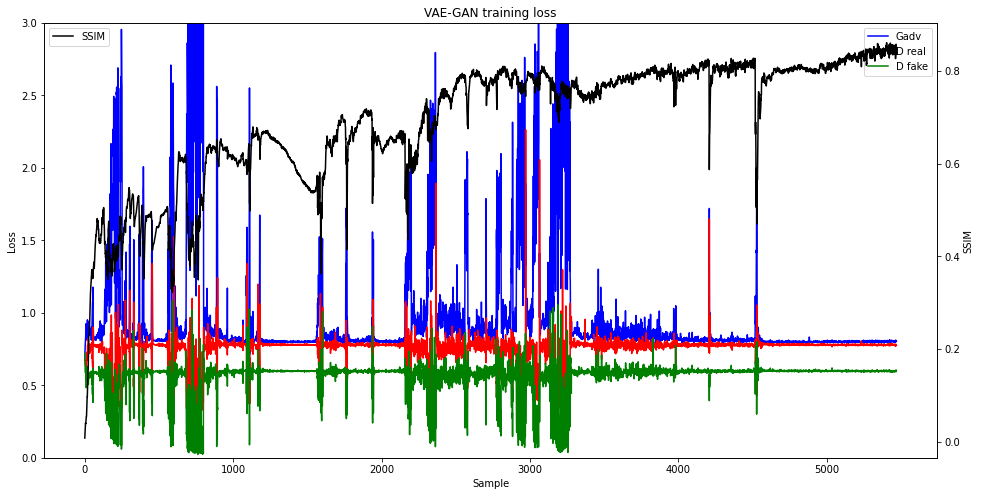

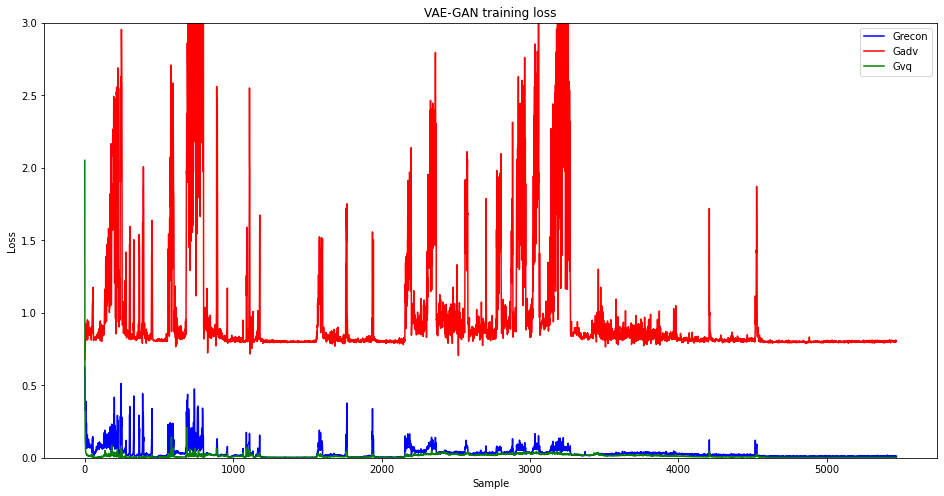

In [1]:
import matplotlib.pyplot as plt
import os, pickle

# model_save_path = 'models/gan_vqvae_skip/'

# with open(os.path.join(model_save_path, 'history.p'), 'rb') as f:
#     history = pickle.load(f)

with open('models/history/vaegan.p', 'rb') as f:
    history = pickle.load(f)
    
plt.close('all')
fig,ax = plt.subplots(1,1,figsize=(16,8))
ax.plot(history['Gadv'], 'b-')
ax.plot(history['Dreal'], 'r-')
ax.plot(history['Dfake'], 'g-')
ax.set_title('VAE-GAN training loss')
ax.set_xlabel('Sample')
ax.set_ylabel('Loss')
ax.legend(['Gadv', 'D real', 'D fake'])

ax2 = ax.twinx()
ax2.plot(history['SSIM'], 'k-')
ax2.set_ylabel('SSIM')
ax2.legend(['SSIM'])
#ax2.set_ylim([0.8,1.0])
#ax.set_xlim([0,7000])
ax.set_ylim([0,3])

plt.show()

plt.close('all')
fig,ax = plt.subplots(1,1,figsize=(16,8))
ax.plot(history['Grecon'], 'b-')
ax.plot(history['Gadv'], 'r-')
ax.plot(history['Gvq'], 'g-')
ax.set_title('VAE-GAN training loss')
ax.set_xlabel('Sample')
ax.set_ylabel('Loss')
ax.legend(['Grecon', 'Gadv', 'Gvq'])
#ax.set_xlim([0, 7000])
ax.set_ylim([0,3])

plt.show()